## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]


"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.5, 0.9]
redice_lr_patient = [1, 5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 19:20:50.109961 140165273626432 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 19:20:50.112123 140165273626432 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 19:20:50.117597 140165273626432 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 19:20:50.265275 140165273626432 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecate

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1


W0723 19:20:50.660352 140165273626432 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 19:20:50.681319 140165273626432 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0723 19:20:50.872366 140165273626432 deprecation.py:323] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 186us/step - loss: 2.2360 - acc: 0.2642 - val_loss: 2.0931 - val_acc: 0.3077
Epoch 2/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.7472 - acc: 0.3883 - val_loss: 1.8132 - val_acc: 0.3777
Epoch 3/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.6217 - acc: 0.4305 - val_loss: 1.7024 - val_acc: 0.4117
Epoch 4/25
50000/50000 [==============================] - 6s 110us/step - loss: 1.5480 - acc: 0.4558 - val_loss: 1.6381 - val_acc: 0.4338
Epoch 5/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.4934 - acc: 0.4773 - val_loss: 1.6150 - val_acc: 0.4343
Epoch 6/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4480 - acc: 0.4933 - val_loss: 1.5746 - val_acc: 0.4526
Epoch 7/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.4088 - acc: 0.5089 - val_loss: 1.5407 - 

Epoch 21/25
50000/50000 [==============================] - 8s 157us/step - loss: 3.0323 - acc: 0.0990 - val_loss: 3.0114 - val_acc: 0.1034
Epoch 22/25
50000/50000 [==============================] - 8s 159us/step - loss: 3.0308 - acc: 0.0999 - val_loss: 3.0113 - val_acc: 0.1033
Epoch 23/25
50000/50000 [==============================] - 7s 150us/step - loss: 3.0312 - acc: 0.0999 - val_loss: 3.0110 - val_acc: 0.1034
Epoch 24/25
50000/50000 [==============================] - 8s 152us/step - loss: 3.0322 - acc: 0.0995 - val_loss: 3.0109 - val_acc: 0.1035
Epoch 25/25
50000/50000 [==============================] - 8s 153us/step - loss: 3.0315 - acc: 0.1001 - val_loss: 3.0105 - val_acc: 0.1035
Numbers of exp: 2, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
________________________________________________

50000/50000 [==============================] - 7s 133us/step - loss: 3.1129 - acc: 0.0853 - val_loss: 3.1321 - val_acc: 0.0825
Epoch 8/25
50000/50000 [==============================] - 7s 137us/step - loss: 3.1137 - acc: 0.0863 - val_loss: 3.1319 - val_acc: 0.0824
Epoch 9/25
50000/50000 [==============================] - 7s 147us/step - loss: 3.1131 - acc: 0.0860 - val_loss: 3.1318 - val_acc: 0.0825

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.2500001034254637e-09.
Epoch 10/25
50000/50000 [==============================] - 8s 154us/step - loss: 3.1134 - acc: 0.0849 - val_loss: 3.1320 - val_acc: 0.0824

Epoch 00010: ReduceLROnPlateau reducing learning rate to 6.250000517127319e-10.
Epoch 11/25
50000/50000 [==============================] - 9s 181us/step - loss: 3.1136 - acc: 0.0856 - val_loss: 3.1321 - val_acc: 0.0824

Epoch 00011: ReduceLROnPlateau reducing learning rate to 3.1250002585636594e-10.
Epoch 12/25
50000/50000 [==============================] - 6s 125us/step -

50000/50000 [==============================] - 8s 153us/step - loss: 2.8785 - acc: 0.1161 - val_loss: 2.8619 - val_acc: 0.1161
Epoch 24/25
50000/50000 [==============================] - 7s 148us/step - loss: 2.8792 - acc: 0.1154 - val_loss: 2.8620 - val_acc: 0.1158
Epoch 25/25
50000/50000 [==============================] - 7s 149us/step - loss: 2.8780 - acc: 0.1160 - val_loss: 2.8619 - val_acc: 0.1159
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 4s 85us/step - loss: 2.9798 - acc: 0.1022 - val_loss: 2.9616 - val_acc: 0.1091
Epoch 11/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.9805 - acc: 0.1019 - val_loss: 2.9617 - val_acc: 0.1091
Epoch 12/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.9803 - acc: 0.1025 - val_loss: 2.9616 - val_acc: 0.1087
Epoch 13/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.9800 - acc: 0.1022 - val_loss: 2.9615 - val_acc: 0.1089
Epoch 14/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.9802 - acc: 0.1021 - val_loss: 2.9617 - val_acc: 0.1091
Epoch 15/25
50000/50000 [==============================] - 4s 86us/step - loss: 2.9806 - acc: 0.1027 - val_loss: 2.9618 - val_acc: 0.1091
Epoch 16/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.9807 - acc: 0.1025 - val_loss: 2.9616 - val_acc: 0.1091
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 113us/step - loss: 3.0540 - acc: 0.0981 - val_loss: 3.0447 - val_acc: 0.0952
Epoch 2/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0533 - acc: 0.0986 - val_loss: 3.0448 - val_acc: 0.0953
Epoch 3/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0547 - acc: 0.0981 - val_loss: 3.0448 - val_acc: 0.0952
Epoch 4/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0541 - acc: 0.0981 - val_loss: 3.0443 - val_acc: 0.0952
Epoch 5/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0544 - acc: 0.0990 - val_loss: 3.0446 - val_acc: 0.0953
Epoch 6/25
50000/50000 [==============================] - 5s 94us/step - loss: 3.0546 - acc: 0.0985 - val_loss: 3.0448 - val_acc: 0.0952
Epoch 7/25
50000/50000 [==============================] - 5s 93us/step - loss: 3.0542 - acc: 0.0980 - val_loss: 3.0448 - val_ac

50000/50000 [==============================] - 5s 100us/step - loss: 1.1021 - acc: 0.6210 - val_loss: 1.3405 - val_acc: 0.5274

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 21/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1018 - acc: 0.6207 - val_loss: 1.3405 - val_acc: 0.5276

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 22/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.1022 - acc: 0.6210 - val_loss: 1.3405 - val_acc: 0.5275

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 23/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1026 - acc: 0.6200 - val_loss: 1.3405 - val_acc: 0.5273
Epoch 24/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.1022 - acc: 0.6222 - val_loss: 1.3405 - val_acc: 0.5269
Epoch 25/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.1024 - ac

Epoch 6/25
50000/50000 [==============================] - 5s 101us/step - loss: 2.8984 - acc: 0.1286 - val_loss: 2.8861 - val_acc: 0.1303
Epoch 7/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.8993 - acc: 0.1271 - val_loss: 2.8861 - val_acc: 0.1303
Epoch 8/25
50000/50000 [==============================] - 5s 101us/step - loss: 2.8978 - acc: 0.1284 - val_loss: 2.8860 - val_acc: 0.1302
Epoch 9/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.8973 - acc: 0.1288 - val_loss: 2.8859 - val_acc: 0.1303
Epoch 10/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.8977 - acc: 0.1294 - val_loss: 2.8862 - val_acc: 0.1305
Epoch 11/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.8982 - acc: 0.1286 - val_loss: 2.8862 - val_acc: 0.1306
Epoch 12/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.8986 - acc: 0.1290 - val_loss: 2.8862 - val_acc: 0.1305
Epoch 13/25
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 134us/step - loss: 3.1413 - acc: 0.0829 - val_loss: 3.1187 - val_acc: 0.0849
Epoch 2/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.1418 - acc: 0.0829 - val_loss: 3.1180 - val_acc: 0.0848
Epoch 3/25
50000/50000 [==============================] - 6s 110us/step - loss: 3.1422 - acc: 0.0815 - val_loss: 3.1180 - val_acc: 0.0849
Epoch 4/25
50000/50000 [==============================] - 5s 104us/step - loss: 3.1417 - acc: 0.0830 - val_loss: 3.1178 - val_acc: 0.0847
Epoch 5/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.1410 - acc: 0.0826 - val_loss: 3.1179 - val_acc: 0.0848
Epoch 6/25
50000/50000 [==============================] - 5s 105us/step - loss: 3.1422 - acc: 0.0818 - val_loss: 3.1180 - val_acc: 0.0848
Epoch 7/25
50000/50000 [==============================] - 5s 104us/step - loss: 3.1417 - acc: 0.0824 - val_loss: 3.1184 - 

Epoch 24/25
50000/50000 [==============================] - 5s 101us/step - loss: 3.0397 - acc: 0.1055 - val_loss: 3.0307 - val_acc: 0.1058
Epoch 25/25
50000/50000 [==============================] - 5s 101us/step - loss: 3.0388 - acc: 0.1058 - val_loss: 3.0308 - val_acc: 0.1056
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 5s 103us/step - loss: 3.1095 - acc: 0.0928 - val_loss: 3.0956 - val_acc: 0.0947
Epoch 12/25
50000/50000 [==============================] - 5s 101us/step - loss: 3.1082 - acc: 0.0944 - val_loss: 3.0955 - val_acc: 0.0948
Epoch 13/25
50000/50000 [==============================] - 5s 102us/step - loss: 3.1091 - acc: 0.0942 - val_loss: 3.0955 - val_acc: 0.0947
Epoch 14/25
50000/50000 [==============================] - 5s 103us/step - loss: 3.1113 - acc: 0.0935 - val_loss: 3.0956 - val_acc: 0.0946
Epoch 15/25
50000/50000 [==============================] - 5s 102us/step - loss: 3.1085 - acc: 0.0935 - val_loss: 3.0956 - val_acc: 0.0946
Epoch 16/25
50000/50000 [==============================] - 5s 101us/step - loss: 3.1091 - acc: 0.0945 - val_loss: 3.0955 - val_acc: 0.0946
Epoch 17/25
50000/50000 [==============================] - 5s 102us/step - loss: 3.1092 - acc: 0.0942 - val_loss: 3.0955 - val_acc: 0.0946
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.8012 - acc: 0.3751 - val_loss: 2.1598 - val_acc: 0.3012
Epoch 2/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.5327 - acc: 0.4593 - val_loss: 2.0973 - val_acc: 0.3060
Epoch 3/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.4304 - acc: 0.4933 - val_loss: 1.8555 - val_acc: 0.3545
Epoch 4/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.3535 - acc: 0.5227 - val_loss: 2.1751 - val_acc: 0.3125

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2106 - acc: 0.5759 - val_loss: 1.5861 - val_acc: 0.4377
Epoch 6/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1683 - acc: 0.5948 - val_loss: 1.4968 - val_acc: 0.4673
Epoch 7/25
50000/50000 [=================

50000/50000 [==============================] - 5s 100us/step - loss: 3.0849 - acc: 0.0983 - val_loss: 3.0837 - val_acc: 0.0990
Epoch 19/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0844 - acc: 0.0979 - val_loss: 3.0838 - val_acc: 0.0991
Epoch 20/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0848 - acc: 0.0978 - val_loss: 3.0840 - val_acc: 0.0990
Epoch 21/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0855 - acc: 0.0984 - val_loss: 3.0839 - val_acc: 0.0988
Epoch 22/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0861 - acc: 0.0984 - val_loss: 3.0837 - val_acc: 0.0989
Epoch 23/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0854 - acc: 0.0978 - val_loss: 3.0840 - val_acc: 0.0987
Epoch 24/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0851 - acc: 0.0983 - val_loss: 3.0838 - val_acc: 0.0986
Epoch 25/25
50000/50000 [==============

50000/50000 [==============================] - 5s 98us/step - loss: 3.0210 - acc: 0.0947 - val_loss: 3.0127 - val_acc: 0.0950
Epoch 6/25
50000/50000 [==============================] - 5s 99us/step - loss: 3.0202 - acc: 0.0949 - val_loss: 3.0129 - val_acc: 0.0948
Epoch 7/25
50000/50000 [==============================] - 5s 99us/step - loss: 3.0210 - acc: 0.0953 - val_loss: 3.0126 - val_acc: 0.0949
Epoch 8/25
50000/50000 [==============================] - 5s 101us/step - loss: 3.0205 - acc: 0.0960 - val_loss: 3.0129 - val_acc: 0.0949
Epoch 9/25
50000/50000 [==============================] - 6s 123us/step - loss: 3.0221 - acc: 0.0954 - val_loss: 3.0127 - val_acc: 0.0950
Epoch 10/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0201 - acc: 0.0956 - val_loss: 3.0125 - val_acc: 0.0948
Epoch 11/25
50000/50000 [==============================] - 5s 99us/step - loss: 3.0210 - acc: 0.0950 - val_loss: 3.0125 - val_acc: 0.0949
Epoch 12/25
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 163us/step - loss: 3.0498 - acc: 0.0943 - val_loss: 3.0456 - val_acc: 0.0942
Epoch 2/25
50000/50000 [==============================] - 5s 105us/step - loss: 3.0501 - acc: 0.0948 - val_loss: 3.0454 - val_acc: 0.0942
Epoch 3/25
50000/50000 [==============================] - 5s 106us/step - loss: 3.0489 - acc: 0.0937 - val_loss: 3.0456 - val_acc: 0.0943
Epoch 4/25
50000/50000 [==============================] - 5s 105us/step - loss: 3.0494 - acc: 0.0936 - val_loss: 3.0452 - val_acc: 0.0942
Epoch 5/25
50000/50000 [==============================] - 5s 104us/step - loss: 3.0499 - acc: 0.0939 - val_loss: 3.0456 - val_acc: 0.0944
Epoch 6/25
50000/50000 [==============================] - 5s 99us/step - loss: 3.0486 - acc: 0.0954 - val_loss: 3.0459 - val_acc: 0.0944
Epoch 7/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.0489 - acc: 0.0937 - val_loss: 3.0457 - v

Epoch 24/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.1501 - acc: 0.0921 - val_loss: 3.1791 - val_acc: 0.0912
Epoch 25/25
50000/50000 [==============================] - 5s 100us/step - loss: 3.1492 - acc: 0.0924 - val_loss: 3.1793 - val_acc: 0.0912
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 5s 100us/step - loss: 2.9763 - acc: 0.1059 - val_loss: 2.9424 - val_acc: 0.1045
Epoch 12/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.9759 - acc: 0.1054 - val_loss: 2.9425 - val_acc: 0.1044
Epoch 13/25
50000/50000 [==============================] - 5s 99us/step - loss: 2.9747 - acc: 0.1048 - val_loss: 2.9423 - val_acc: 0.1044
Epoch 14/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.9756 - acc: 0.1052 - val_loss: 2.9422 - val_acc: 0.1044
Epoch 15/25
50000/50000 [==============================] - 5s 99us/step - loss: 2.9761 - acc: 0.1047 - val_loss: 2.9423 - val_acc: 0.1044
Epoch 16/25
50000/50000 [==============================] - 5s 99us/step - loss: 2.9752 - acc: 0.1045 - val_loss: 2.9425 - val_acc: 0.1043
Epoch 17/25
50000/50000 [==============================] - 5s 99us/step - loss: 2.9762 - acc: 0.1054 - val_loss: 2.9426 - val_acc: 0.1043
Epoch 18/25
50000/50000 [===================

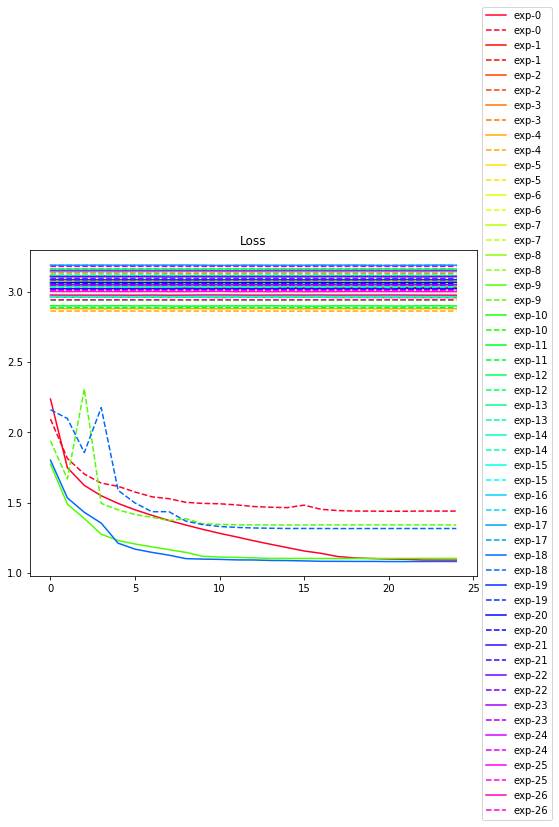

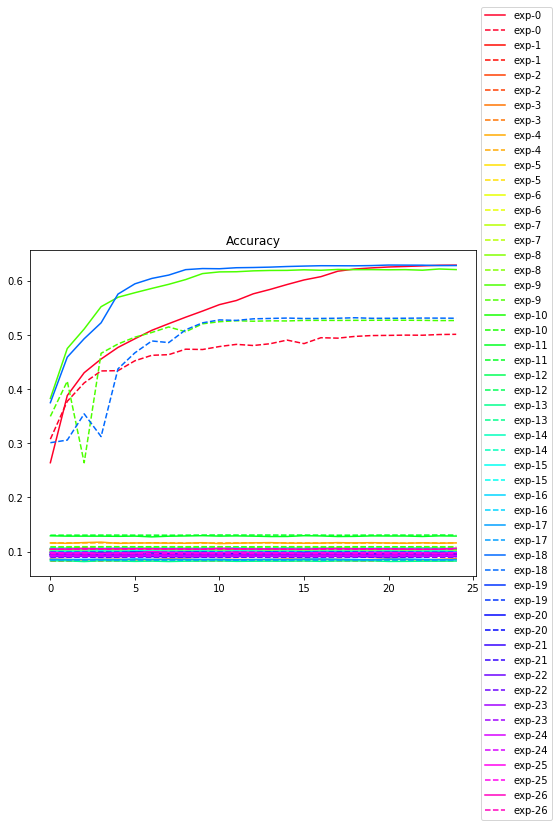

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()